# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

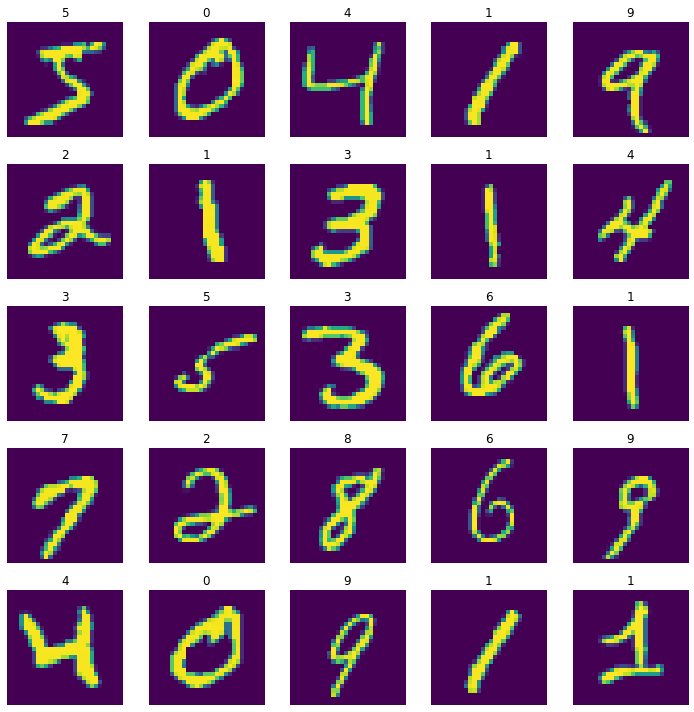

In [4]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

# Plot the first 25 images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.ravel()

for i in range(25):
    axes[i].imshow(x_train[i])
    axes[i].set_title(y_train[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()
    
# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape((-1, num_features)), x_test.reshape((-1, num_features))

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
x_train.shape

(60000, 784)

In [6]:
x_test.shape

(10000, 784)

In [7]:
y_train.shape

(60000,)

In [95]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="weight")
        self.b = tf.Variable(tf.zeros([out_features]), name="bias")

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Первый слой, состоящий из 128 нейронов
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

        # Второй слой, состоящий из 256 нейронов
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

        # Выходной слой
        self.layer_out = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):
        # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
        # Делаем мы это для того, чтобы
        # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
        # принадлежности входного объекта к одному из 10 классов
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_out(x)
        return tf.nn.softmax(x)

In [96]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1)

    # Вычисление кросс-энтропии
    # y_true (256, 10) * log(y_pred) (256, 10) -> (256, 10) -> sum(axis=1) -> (256,) -> reduce_mean -> (1,)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))


# В качестве метрики качества используем точность
# check the arg max of prediction equal to label, then compute the mean product the accuracy
def accuracy(y_pred, y_true):

    corr_pred = tf.equal(tf.argmax(y_pred, axis=1), tf.cast(y_true, dtype=tf.int64))
    acc = tf.reduce_mean(tf.cast(corr_pred, dtype=tf.float32))
    return 1 - acc

In [97]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    # use neural_net to compute the model's predictionsfor given input 
    pred = nn(input_x)
    # compute the loss between the predicted values pred and the true values output_y
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    # get a list of all trainable variables in the model
    trainable_variables = nn.trainable_variables
    #print("trainable_variables:",trainable_variables)
    
    # use the gradients to update the trainable variables in the neural network
    
    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [98]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
acc_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети
epoch_history = []
# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.

# Train the model for the specified number of steps
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        
        loss_check = cross_entropy(pred, batch_y)
        loss_history.append(loss_check)
        
        acc_check = accuracy(pred, batch_y)
        acc_history.append(acc_check)
        
        epoch_history.append(step)
        
        print(f"Step {step}: loss = {loss_check:.4f}, acc = {acc_check:.4f}")

Step 0: loss = 2.3727, acc = 0.8750
Step 100: loss = 2.4222, acc = 0.9492
Step 200: loss = 2.3920, acc = 0.9219
Step 300: loss = 2.4116, acc = 0.9258
Step 400: loss = 2.4277, acc = 0.8711
Step 500: loss = 2.3905, acc = 0.9023
Step 600: loss = 2.4336, acc = 0.8828
Step 700: loss = 2.3491, acc = 0.8945
Step 800: loss = 2.3841, acc = 0.8789
Step 900: loss = 2.4363, acc = 0.8984
Step 1000: loss = 2.4255, acc = 0.8867
Step 1100: loss = 2.3807, acc = 0.9023
Step 1200: loss = 2.3720, acc = 0.9062
Step 1300: loss = 2.4326, acc = 0.8945
Step 1400: loss = 2.3923, acc = 0.8750
Step 1500: loss = 2.4109, acc = 0.8984
Step 1600: loss = 2.3968, acc = 0.9102
Step 1700: loss = 2.3468, acc = 0.8906
Step 1800: loss = 2.4218, acc = 0.8906
Step 1900: loss = 2.3708, acc = 0.8906
Step 2000: loss = 2.4054, acc = 0.8945
Step 2100: loss = 2.3743, acc = 0.8867
Step 2200: loss = 2.3910, acc = 0.8789
Step 2300: loss = 2.3858, acc = 0.9023
Step 2400: loss = 2.3635, acc = 0.8789
Step 2500: loss = 2.3918, acc = 0.878

Text(0.5, 0, 'Epoch')

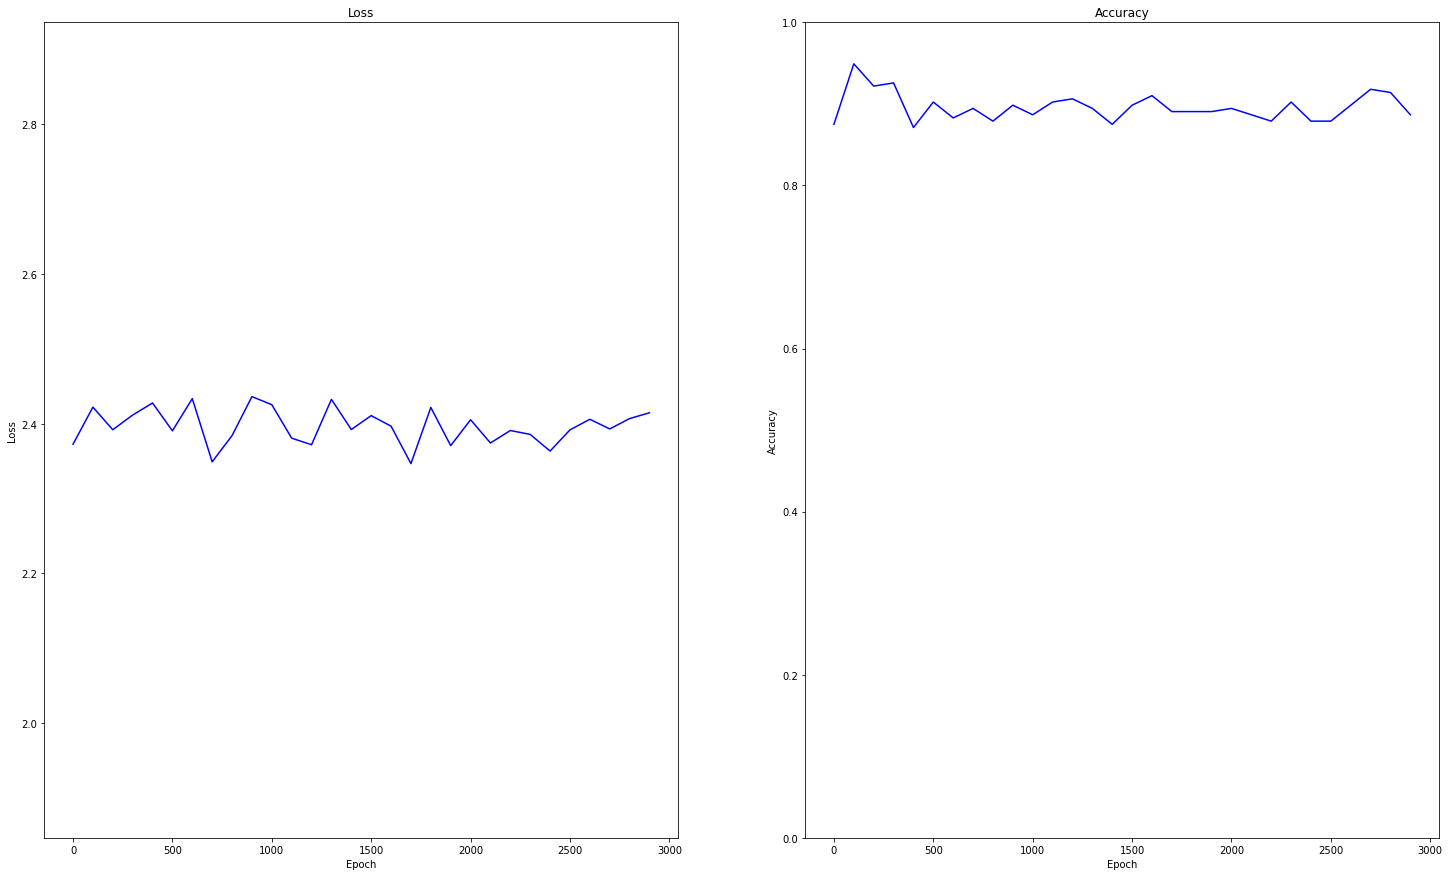

In [99]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,15), sharex=True)

# plot history for loss
ax[0].plot(epoch_history, loss_history, 'b-')
ax[0].set_title('Loss')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(min(loss_history)-0.5, max(loss_history)+0.5)
ax[0].set_xlabel('Epoch')
    
# plot history for F score etc.
ax[1].plot(epoch_history, acc_history, 'b-')
ax[1].set_title('Accuracy')
ax[1].set_ylim(bottom=0., top=1.0)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')

# plot_history(history, validation=True)

In [100]:
# Вычислите точность обученной нейросети
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.int32)

pred = neural_net(x_test)
acc = accuracy(pred, y_test)
print('Accuracy for the test sample: ', acc)

Accuracy for the test sample:  tf.Tensor(0.8972, shape=(), dtype=float32)


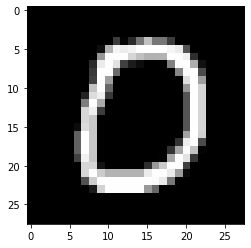

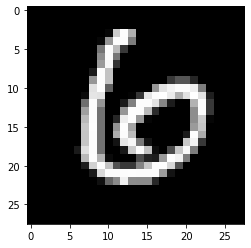

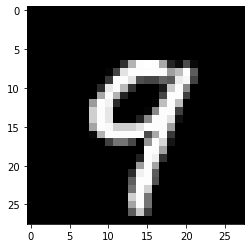

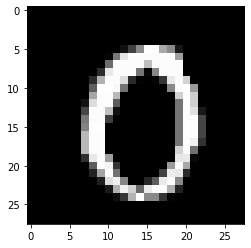

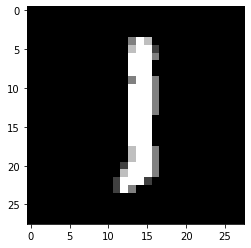

In [102]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

import matplotlib.pyplot as plt
start = 10
n_images = 5
test_images = x_test[start:start + n_images]
predictions = neural_net(x_test[:5])

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], (28, 28)),
               cmap='gray')
    plt.show()
#     print("Model Predictions: %d" % np.argmax(predictions.numpy()[i]))